In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import fsolve
import casadi as ca
import matplotlib.pyplot as plt


In [28]:
np.random.seed(42)
alpha0 = np.random.uniform(0.2, 0.8)
A1 = (2.6)*(10**-3)
Lc = 2
kv = 0.38
P1 = 4.5
P_out = 5
C = 479

def fun(variables, A1, Lc, kv, P1, P_out, C) :
    (x,y) = variables
    eqn_1 = (A1/Lc)* ((1.5 * P1) - y)
    eqn_2 = (C**2)/2 * (x - alpha0 * kv * np.sqrt(y - P_out))
    return [eqn_1, eqn_2]


result = fsolve(fun, (0, 10), args = (A1, Lc, kv, P1, P_out, C)) 

init_m = result[0]
init_p = result[1]
interval = [np.linspace(i * 500, (i + 1) * 500, 500) for i in range(10)]
x = ca.MX.sym('x', 2)
alpha = ca.MX.sym('alpha', 1)
massFlowrate = []
PlenumPressure = []
alpha_values = [np.full(500, alpha0)]
RNN_train = []
RNN_test = []

for i in range(0,10):  
    if i ==0:
        alpha1 = alpha0
    else:
        alpha1 = np.random.uniform(0.2, 0.8)
        alpha_values.append(np.full(500, alpha1))
    
    rhs = ca.vertcat((A1/Lc)*((1.5 * P1) - x[1]), (C**2)/2 * (x[0] - alpha * kv * np.sqrt(x[1] - P_out)))
    ode = {'x' : x, 'ode' : rhs, 'p' : alpha }

    F = ca.integrator('F','idas', ode, interval[i][0], interval[i])
    
    sol = F(x0 = [init_m, init_p], p = alpha1)

    xf_values = np.array(sol["xf"])

    aux1, aux2 = xf_values
    massFlowrate.append(aux1)
    PlenumPressure.append(aux2)
    init_m = aux1[-1]
    init_p = aux2[-1]

    if i < 5:
        RNN_train.append([aux1, aux2, np.full(500,alpha1)])
    else:
        RNN_test.append([aux1, aux2, np.full(500,alpha1)])


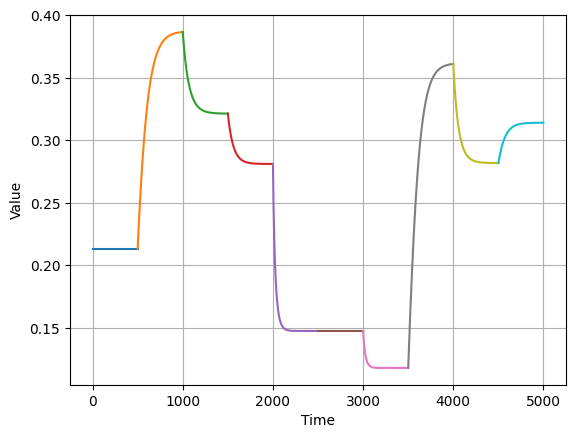

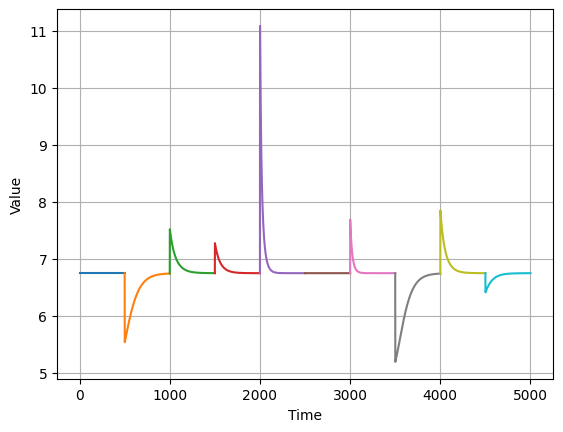

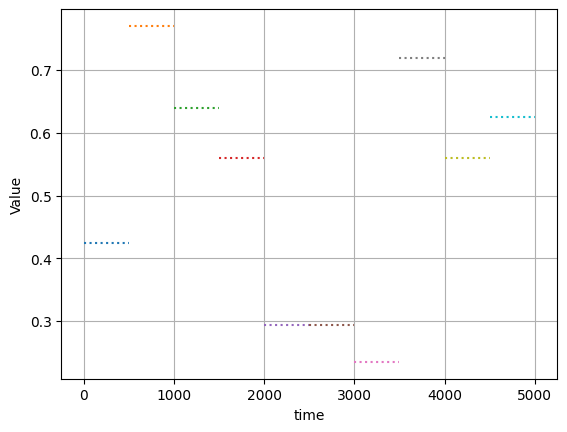

In [29]:
plt.figure("mass flow rate x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(massFlowrate[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("Plenum pressure x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(PlenumPressure[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("alpha x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(alpha_values[i]), linestyle=':')
plt.grid(True)
plt.xlabel('time') 
plt.ylabel('Value')


plt.show()


In [30]:
RNN_train = np.array(RNN_train)
RNN_test = np.array(RNN_test)

timestep = 2

X = []
y = []
x_test = []

for j in range(5):
    for i in range(len(RNN_train[0][0])):
        X.append(RNN_train[j,:,i])
        x_test.append(RNN_test[j,:,i])
        if i == (len(RNN_train[0][0]) - 1):
            if j != 4:
                y.append(RNN_train[j + 1, :2, 0])
            else:
                y.append(RNN_train[0, :2, 0])
        else:
            y.append(RNN_train[j,:2,i+1])

X = np.array(X)
X = tf.reshape(X, [1250, timestep, 3])
y = np.array(y)
y = tf.reshape(y, [1250, timestep, 2])


x_test = np.array(x_test)
x_test = tf.reshape(x_test, [1250, timestep, 3])




In [35]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Supondo que 'timestep' seja definido corretamente
model = keras.Sequential()
model.add(layers.Bidirectional(layers.SimpleRNN(50, input_shape=(timestep, 3), return_sequences=True, activation='tanh')))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2))  # Produz saída (1250, 2, 2)

# Usando Lambda para ajustar a forma
model.add(layers.Lambda(lambda x: x[:, -1:, :]))  # Isso extrai o último timestep

# Compilação do modelo
model.compile(optimizer='adam', loss=lossCustom)

# Treinamento
history = model.fit(X, y, epochs=1000, verbose=1, callbacks=[early_stopping])


def lossCustom(y_true, y_pred):
    weight1 = 1e3
    weight2 = 1
    data_loss = tf.reduce_mean(tf.square(y_true[:, :, 0] - y_pred[:, :, 0]))* weight1 + tf.reduce_mean(tf.square(y_true[:, :, 1] - y_pred[:, :, 1]))*weight2
    return data_loss


model.compile(optimizer = 'adam', loss = lossCustom)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  
    patience=50,     
    restore_best_weights=True 
)

history = model.fit(X, y, epochs=1000, verbose=1, callbacks= [early_stopping])

Epoch 1/1000


ValueError: The total size of the tensor must be unchanged. Received: input_shape=(2, 2), target_shape=(1, 2)

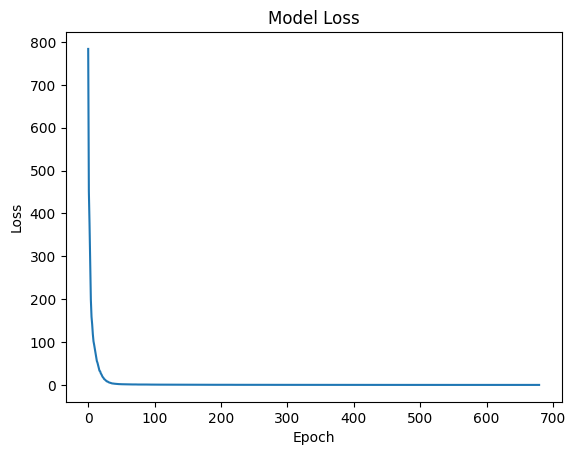

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
(1250, 2, 2)


/tmp/ipykernel_4799/1453252799.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_4799/1453252799.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


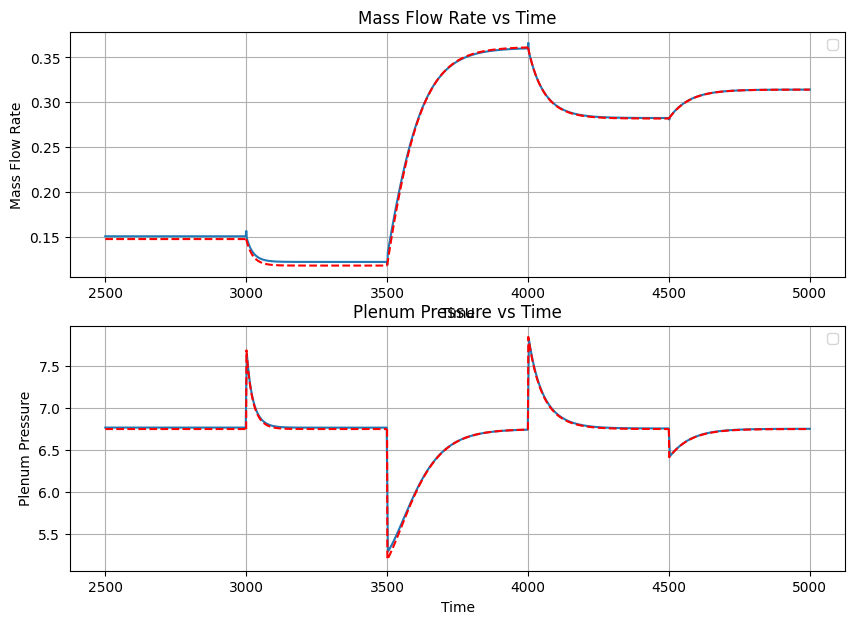

In [34]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

interval2 = [np.linspace(2500, 5000, 1250)]

# Assuming X_new is the new data for prediction

prediction = model.predict(x_test)
print(prediction.shape)

# Extract mass and pressure from prediction

mass = prediction[:,:,0]
pressure = prediction[:, :,1]

# Cria uma figura com subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 7), )

axs[0].plot(interval2[0], np.squeeze(mass[:, 0]))

# Gráfico da mass FlowRate vs. Tempo
for i in range(5, 10):
    axs[0].plot(interval[i], np.squeeze(massFlowrate[i]), 'r--')
axs[0].grid(True)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mass Flow Rate')
axs[0].set_title('Mass Flow Rate vs Time')
axs[0].legend()

# Gráfico da Pressão do PlenumPressure vs. Tempo
axs[1].plot(interval2[0], np.squeeze(pressure[:,0]))
for i in range(5, 10):
    axs[1].plot(interval[i], np.squeeze(PlenumPressure[i]), 'r--')
axs[1].grid(True)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Plenum Pressure')
axs[1].set_title('Plenum Pressure vs Time')
axs[1].legend()

